## Image segmentation using EM 

Segment images using a clustering method - each segment is the cluster center to which a pixel belongs. 

Image pixels are represented by their r, g, and b values. EM algorithm is applied to the mixture of normal distribution model to cluster image pixels, then the image is segmented by mapping each pixel to the cluster center with the highest value of the posterior probability for that pixel.

#### Segment each of the images to 10, 20, and 50 segments. These segmented images are displayed as images, where each pixel's color is replaced with the mean color of the closest segment.

In [120]:
# import libs
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline  

from scipy import misc
from sklearn.cluster import KMeans
from sklearn import preprocessing as pre

In [121]:
def logsumexp(X):
    """
    log sum exp trick for approximation to avoid underflow/ overflow
    :param X: data matrix
    :return: log sum exp applied to each row of input matrix X
    """
    x_max = X.max(1)
    return x_max + np.log(np.exp(X - x_max[:, None]).sum(1))

We use k-means to compute rough cluster centers and mixture weights.

*Caution*: pi should not have a zero-element. An infinitesimal smoothing must be applied in such situations, else no documents may be assigned to the corresponding topic.

*We define a function so we can repeat the process for different images*

In [122]:
CONVERGENCE_THRESHOLD = 100

def EM(X, img_name, W, H, center, scale):    
    """
    Function that performs EM for image segmentation for [10, 20, 50] segments and displays results as image
    :param X: data matrix where each row is [R,G,B]
    """
    plt_num = 1

    estimators = {'k_means_10': KMeans(n_clusters=10),
                  'k_means_20': KMeans(n_clusters=20),
                  'k_means_50': KMeans(n_clusters=50)}
    
    for name, est in estimators.items():
        print(name)
        J = int(name[8:])
        NUM_PIXELS = X.shape[0]
        
        # perform k means
        est.fit(X)
        segments_id = est.labels_
        
        # get initial cluster centers/ means from k-means
        means = est.cluster_centers_
        
        # get initial pi from k-means
        pi = np.array([np.sum(segments_id == i) for i in range(J)])
        pi = pi / float(NUM_PIXELS)

        # check that there are no zero values in pi's
        print("check there are no zero values in pi", 0 not in pi)
        
        ### EM ###
        prev_Q = sys.maxsize
        list_of_q = []
        
        while True:
            
            ## E-Step ##
            ll = np.zeros((NUM_PIXELS, J))
            for j in range(J):
                ll[:,j] = -0.5 * np.sum((X - means[j,])**2, 1)
            
            # compute w_ij
            w = np.exp(ll) @ np.diag(pi)
            w = (w.T / np.sum(w,1)).T
            
            # compute Q without constant K
            Q = np.sum(ll * w)
            list_of_q.append(Q)
            
            # check for convergence
            if abs(Q - prev_Q) <= CONVERGENCE_THRESHOLD:
                break
            else:
                prev_Q = Q
            
            ## M-Step ##
            
            # update means
            for j in range(J):
                means[j,] = np.sum((X.T * w[:,j]).T, 0) / np.sum(w[:,j])

            # update pi
            pi = np.sum(w, 0)/ NUM_PIXELS
            
        # plot convergence of Q as we progress through EM
        plt.figure(plt_num)
        plt.plot(list_of_q)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Q at E-step")
        plt.show()
        plt_num += 1
            
        # display result as segmented image
        segmented_img_rgb = np.zeros((H, W, 3), dtype=np.uint8)
        for i in range(H):
            for j in range(W):
                idx = (i-1) * W + j
                pixel = X[idx,]
                pixel_segment_id = np.argmax(w[idx,])
                segmented_img_rgb[i,j,] = means[pixel_segment_id,] * scale + center
        
        plt.figure(plt_num)
        plt.imshow(segmented_img_rgb) # show segmented image
        plt.show()
        plt_num += 1
        misc.imsave('images/' + img_name + name + '.jpg', segmented_img_rgb) # save segmented image

**Note: We scale data below so that mean along columns is zero and variance is 1 to simplify computation in E-Step**

*Therefore, we have to un-scale our means before we generate segmented image*

/Users/Zubin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


k_means_20
check there are no zero values in pi True


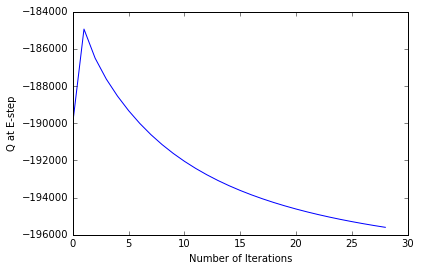

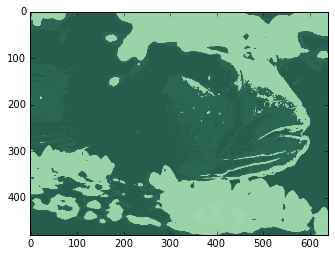

k_means_50
check there are no zero values in pi True


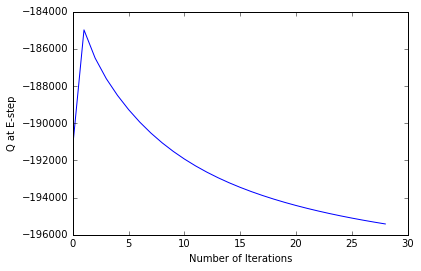

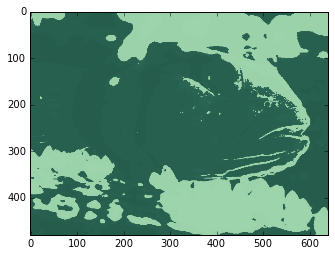

k_means_10
check there are no zero values in pi True


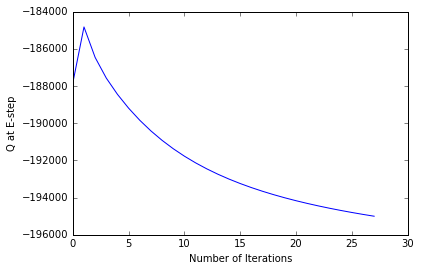

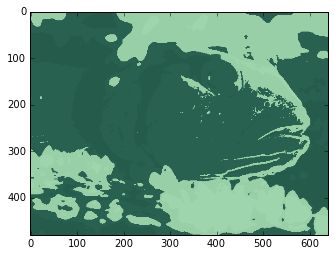

In [112]:
# read data
goby_img = misc.imread('images/goby.jpg')
(H, W, N) = goby_img.shape
data = goby_img.reshape((H * W, N))
data_centers = np.mean(data, 0)
data_scale = np.std(data, 0)
data = pre.scale(data)

# run EM
EM(data, 'goby_', W, H, data_centers, data_scale)

### Now we repeat above process for two other images

/Users/Zubin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


k_means_20
check there are no zero values in pi True


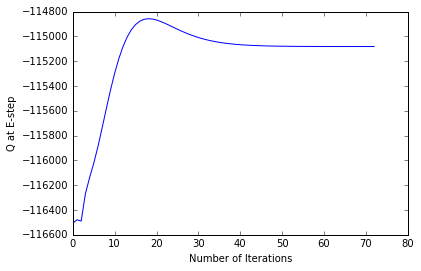

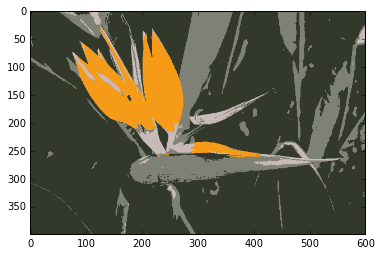

k_means_50
check there are no zero values in pi True


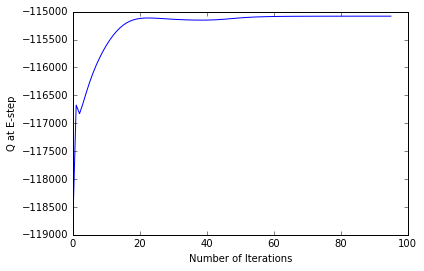

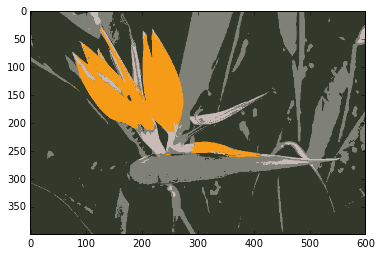

k_means_10
check there are no zero values in pi True


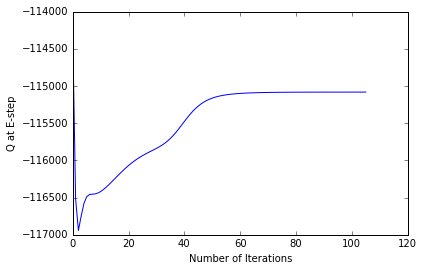

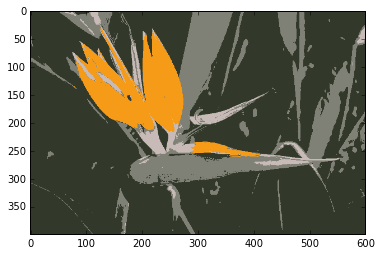

In [123]:
CONVERGENCE_THRESHOLD = 0.01

# read data
strelitzia_img = misc.imread('images/strelitzia.jpg')
(H, W, N) = strelitzia_img.shape
data = strelitzia_img.reshape((H * W, N))
data_centers = np.mean(data, 0)
data_scale = np.std(data, 0)
data = pre.scale(data)

# run EM
EM(data, 'strelitzia_', W, H, data_centers, data_scale)

/Users/Zubin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


k_means_20
check there are no zero values in pi True


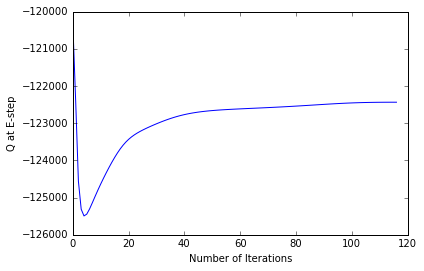

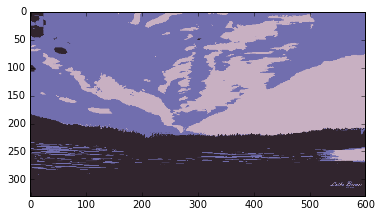

k_means_50
check there are no zero values in pi True


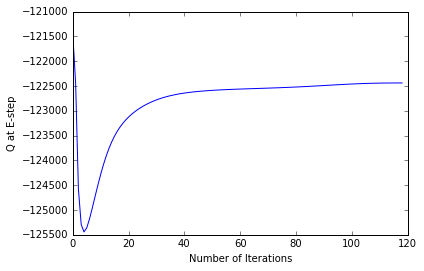

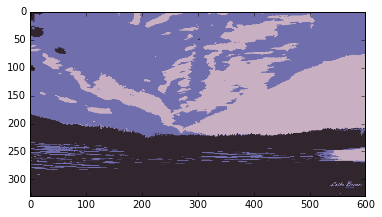

k_means_10
check there are no zero values in pi True


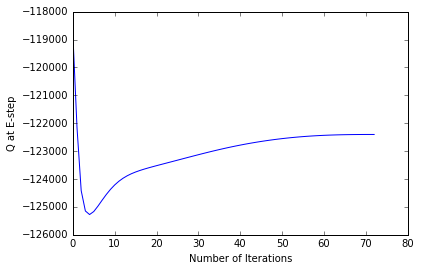

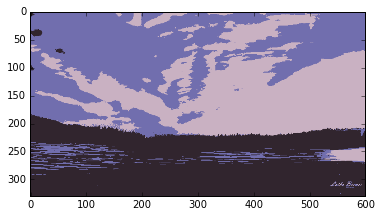

In [124]:
CONVERGENCE_THRESHOLD = 0.1

# read data
sunset_img = misc.imread('images/sunset.jpg')
(H, W, N) = sunset_img.shape
data = sunset_img.reshape((H * W, N))
data_centers = np.mean(data, 0)
data_scale = np.std(data, 0)
data = pre.scale(data)

# run EM
EM(data, 'sunset_', W, H, data_centers, data_scale)

### Segment the sunset image to 20 segments using five different start points, and display the result for each case. 

We start with different k-means settings. Each setting will give us different starting point. When we set *n_init = 1* we should expect a bad starting point.

**We copy above function for EM and change estimators.**

In [125]:
CONVERGENCE_THRESHOLD = 10

def EM(X, img_name, W, H, center, scale):    
    """
    Function that performs EM for image segmentation for [10, 20, 50] segments and displays results as image
    :param X: data matrix where each row is [R,G,B]
    """
    plt_num = 1

    estimators = {'k_means++'       : KMeans(n_clusters=20),
                  'k_means_random_1': KMeans(n_clusters=20, init='random', random_state=1),
                  'k_means_random_2': KMeans(n_clusters=20, init='random', random_state=2),
                  'k_means_random_3': KMeans(n_clusters=20, n_init=1, init='random', random_state=3),
                  'k_means_random_4': KMeans(n_clusters=20, n_init=1, init='random', random_state=4)}
    
    for name, est in estimators.items():
        print(name)
        J = 20
        NUM_PIXELS = X.shape[0]
        
        # perform k means
        est.fit(X)
        segments_id = est.labels_
        
        # get initial cluster centers/ means from k-means
        means = est.cluster_centers_
        
        # get initial pi from k-means
        pi = np.array([np.sum(segments_id == i) for i in range(J)])
        pi = pi / float(NUM_PIXELS)

        # check that there are no zero values in pi's
        if (0 in pi):
            print("ABORT: one of the segments has mixture weight set to zero initially")
            return
        
        ### EM ###
        prev_Q = sys.maxsize
        list_of_q = []
        
        while True:
            
            ## E-Step ##
            ll = np.zeros((NUM_PIXELS, J))
            for j in range(J):
                ll[:,j] = -0.5 * np.sum((X - means[j,])**2, 1)
            
            # compute w_ij
            w = np.exp(ll) @ np.diag(pi)
            w = (w.T / np.sum(w,1)).T
            
            # compute Q without constant K
            Q = np.sum(ll * w)
            list_of_q.append(Q)
            
            # check for convergence
            if abs(Q - prev_Q) <= CONVERGENCE_THRESHOLD:
                break
            else:
                prev_Q = Q
            
            ## M-Step ##
            
            # update means
            for j in range(J):
                means[j,] = np.sum((X.T * w[:,j]).T, 0) / np.sum(w[:,j])

            # update pi
            pi = np.sum(w, 0)/ NUM_PIXELS
            
        # plot convergence of Q as we progress through EM
        plt.figure(plt_num)
        plt.plot(list_of_q)
        plt.xlabel("Number of Iterations")
        plt.ylabel("Q at E-step")
        plt.show()
        plt_num += 1
            
        # display result as segmented image
        segmented_img_rgb = np.zeros((H, W, 3), dtype=np.uint8)
        for i in range(H):
            for j in range(W):
                idx = (i-1) * W + j
                pixel = X[idx,]
                pixel_segment_id = np.argmax(w[idx,])
                segmented_img_rgb[i,j,] = means[pixel_segment_id,] * scale + center
        
        plt.figure(plt_num)
        plt.imshow(segmented_img_rgb) # show segmented image
        plt.show()
        plt_num += 1
        misc.imsave('images/' + img_name + name + '.jpg', segmented_img_rgb) # save segmented image

/Users/Zubin/anaconda/lib/python3.5/site-packages/sklearn/utils/validation.py:420: DataConversionWarning: Data with input dtype uint8 was converted to float64 by the scale function.
  warnings.warn(msg, DataConversionWarning)


k_means_random_3


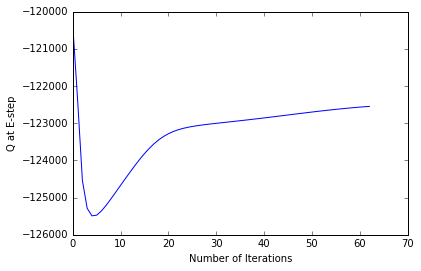

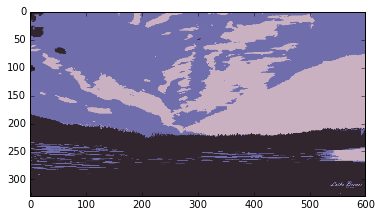

k_means_random_1


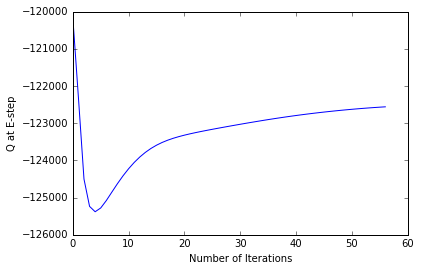

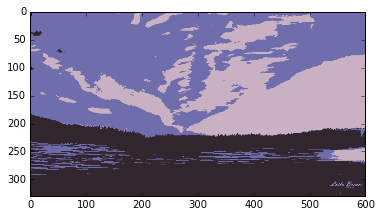

k_means_random_2


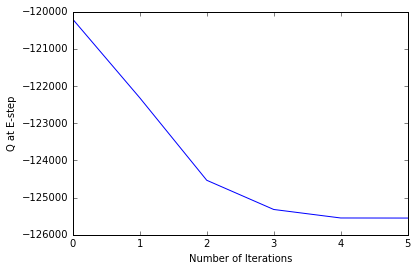

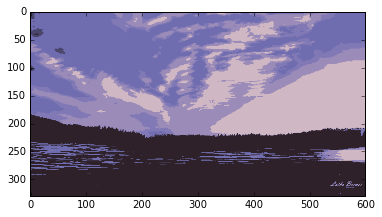

k_means++


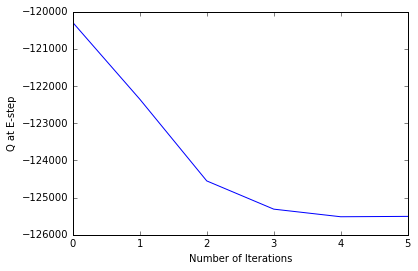

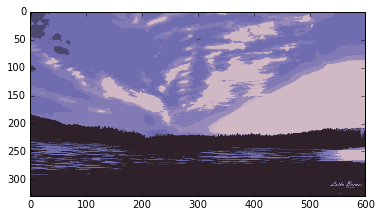

k_means_random_4


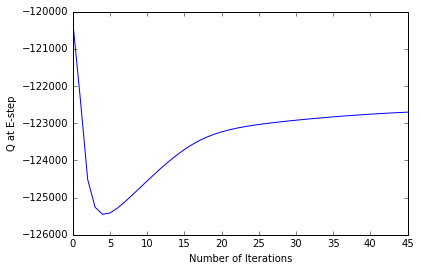

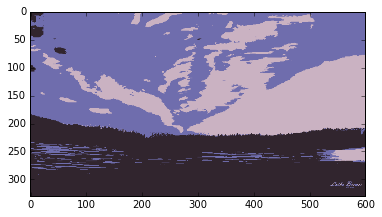

In [126]:
# read data
sunset_img = misc.imread('images/sunset.jpg')
(H, W, N) = sunset_img.shape
data = sunset_img.reshape((H * W, N))
data_centers = np.mean(data, 0)
data_scale = np.std(data, 0)
data = pre.scale(data)

# EM
EM(data, 'sunset_', W, H, data_centers, data_scale)